# Make plots for paper

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import dill

In [3]:
# load run
run_fn = 'run6'

# load PTA
with open(f'runs/{run_fn}/pta.pkl', 'rb') as f:
    pta = dill.load(f)

# load samples
with open(f'runs/{run_fn}/samples.pkl', 'rb') as f:
    samples = dill.load(f)

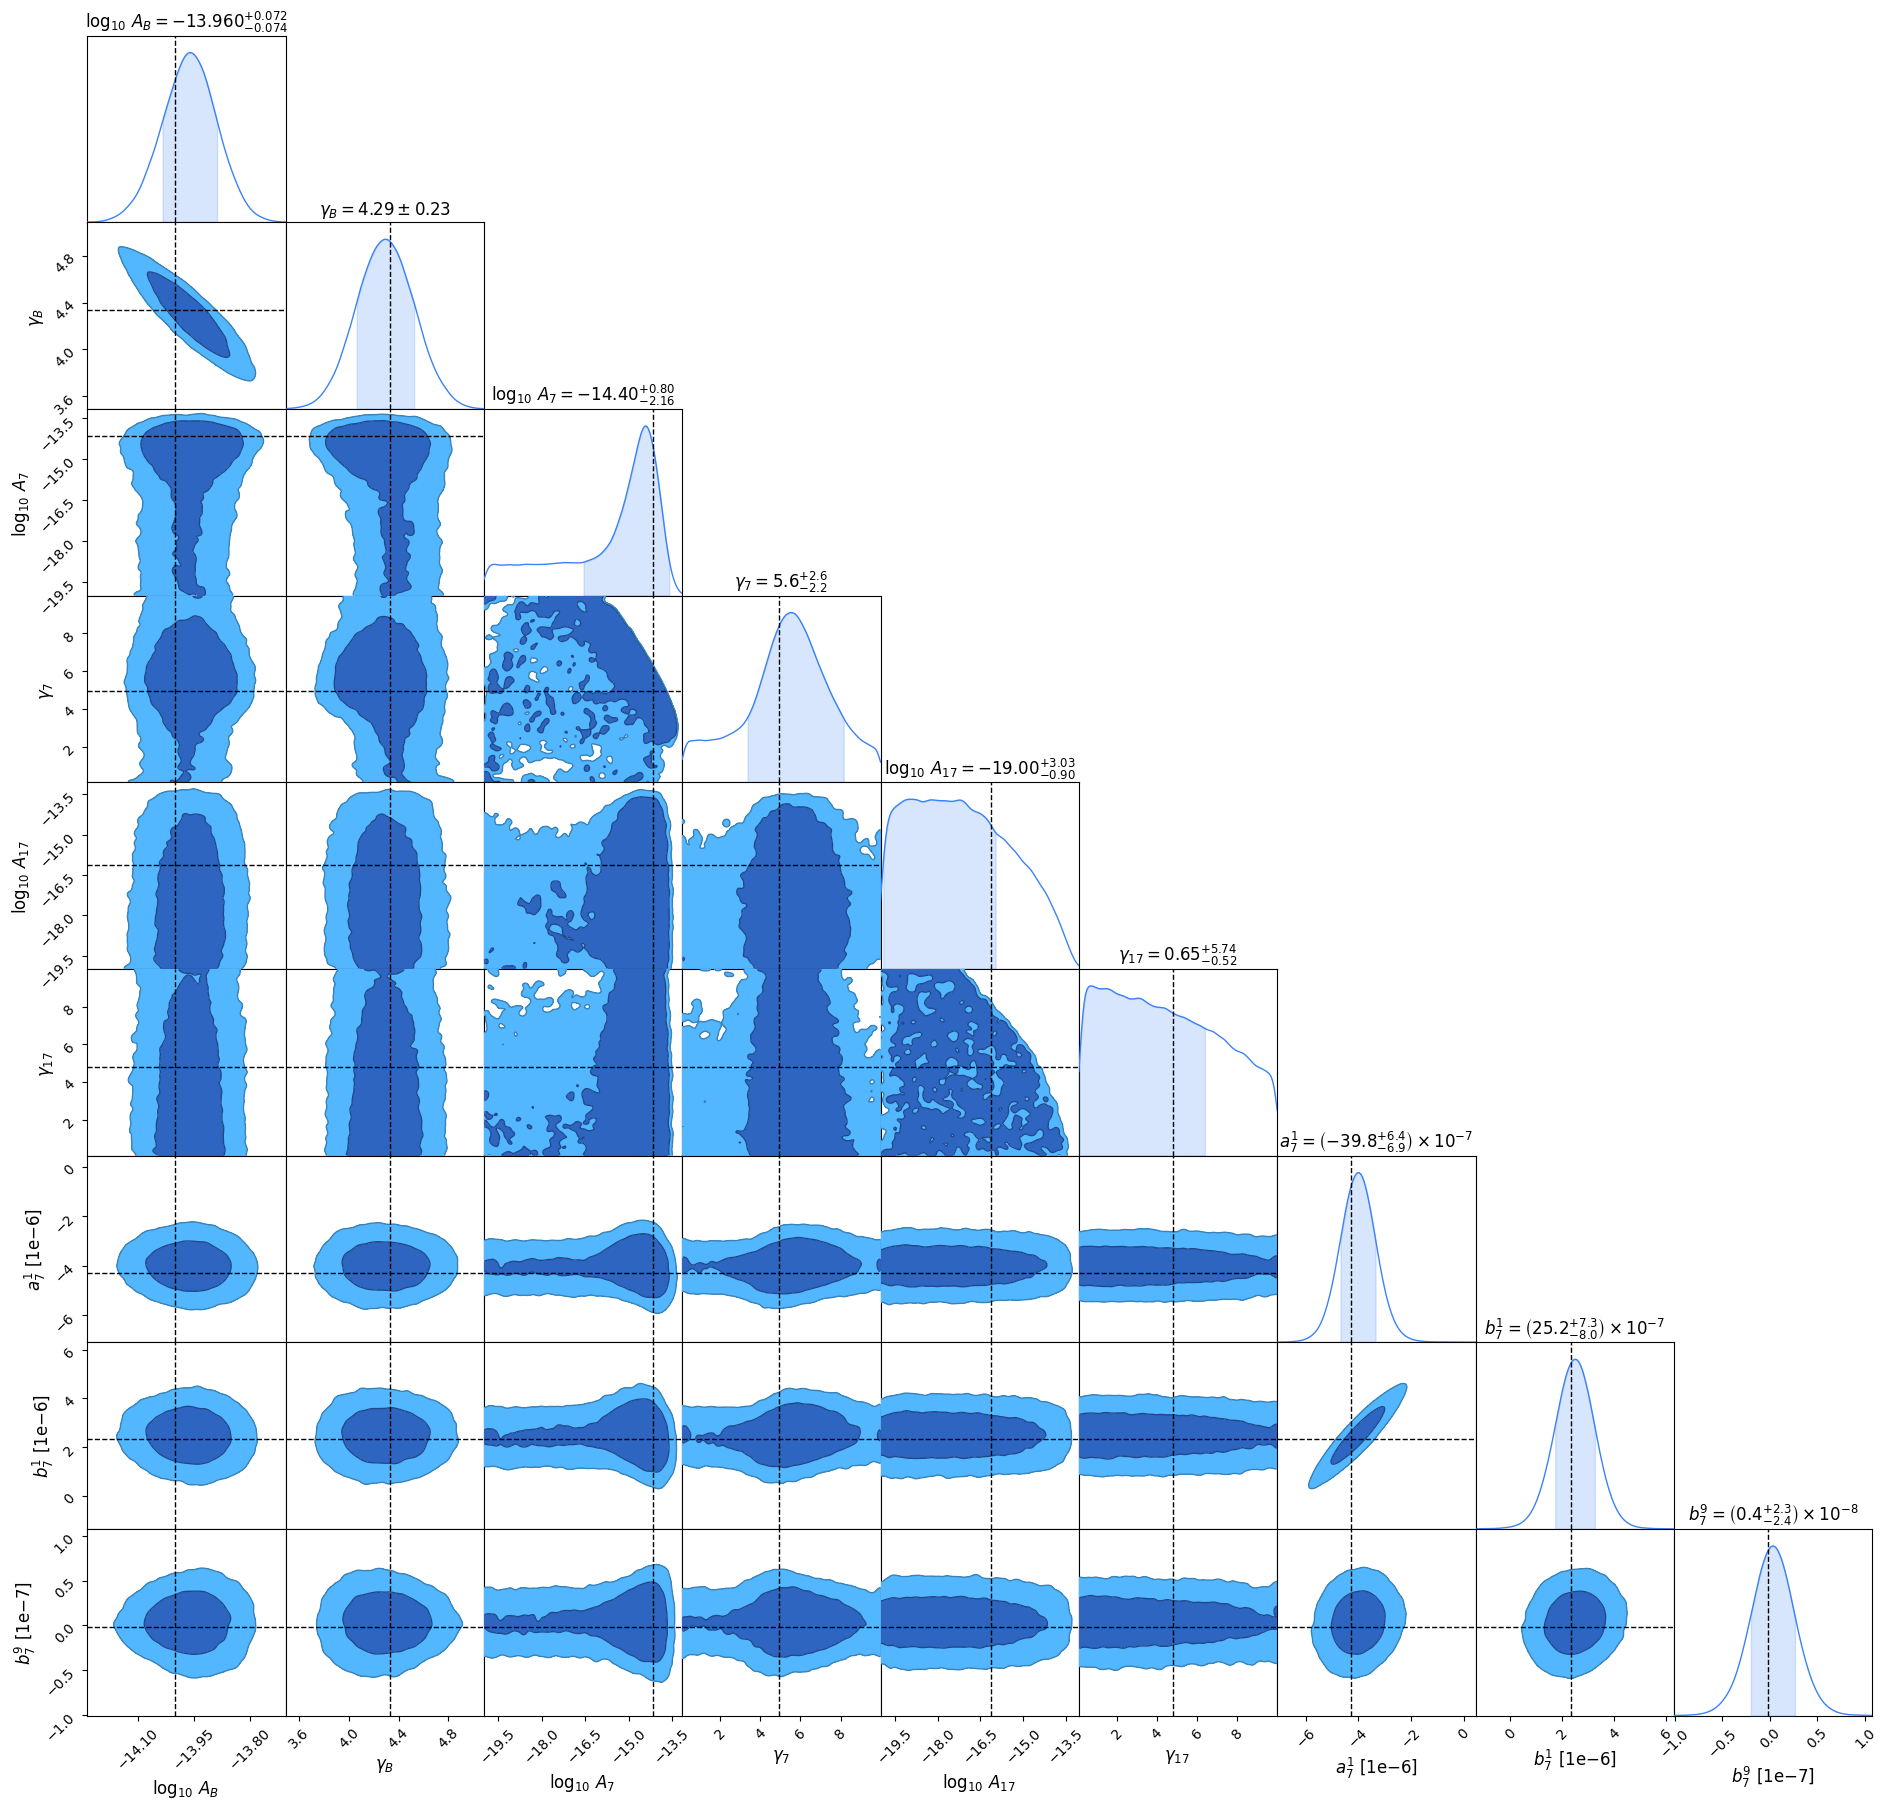

In [18]:
ndxs = np.concatenate((pta.gwb_ndxs,
                       pta.rn_ndxs.reshape((pta.Np, 2))[np.r_[6, 16]].flatten(),
                       pta.a_ndxs.reshape((pta.Np, pta.Na))[6, np.r_[:2, -3:-2]]))
samples.corner_plt(param_ndxs=ndxs, burnin=10_000, thin=2)

Parameter $\Phi$ [1] in chain samples is not constrained
Parameter $\Phi$ [2] in chain samples is not constrained
Parameter $\Phi$ [3] in chain samples is not constrained
Parameter $\Phi$ [5] in chain samples is not constrained


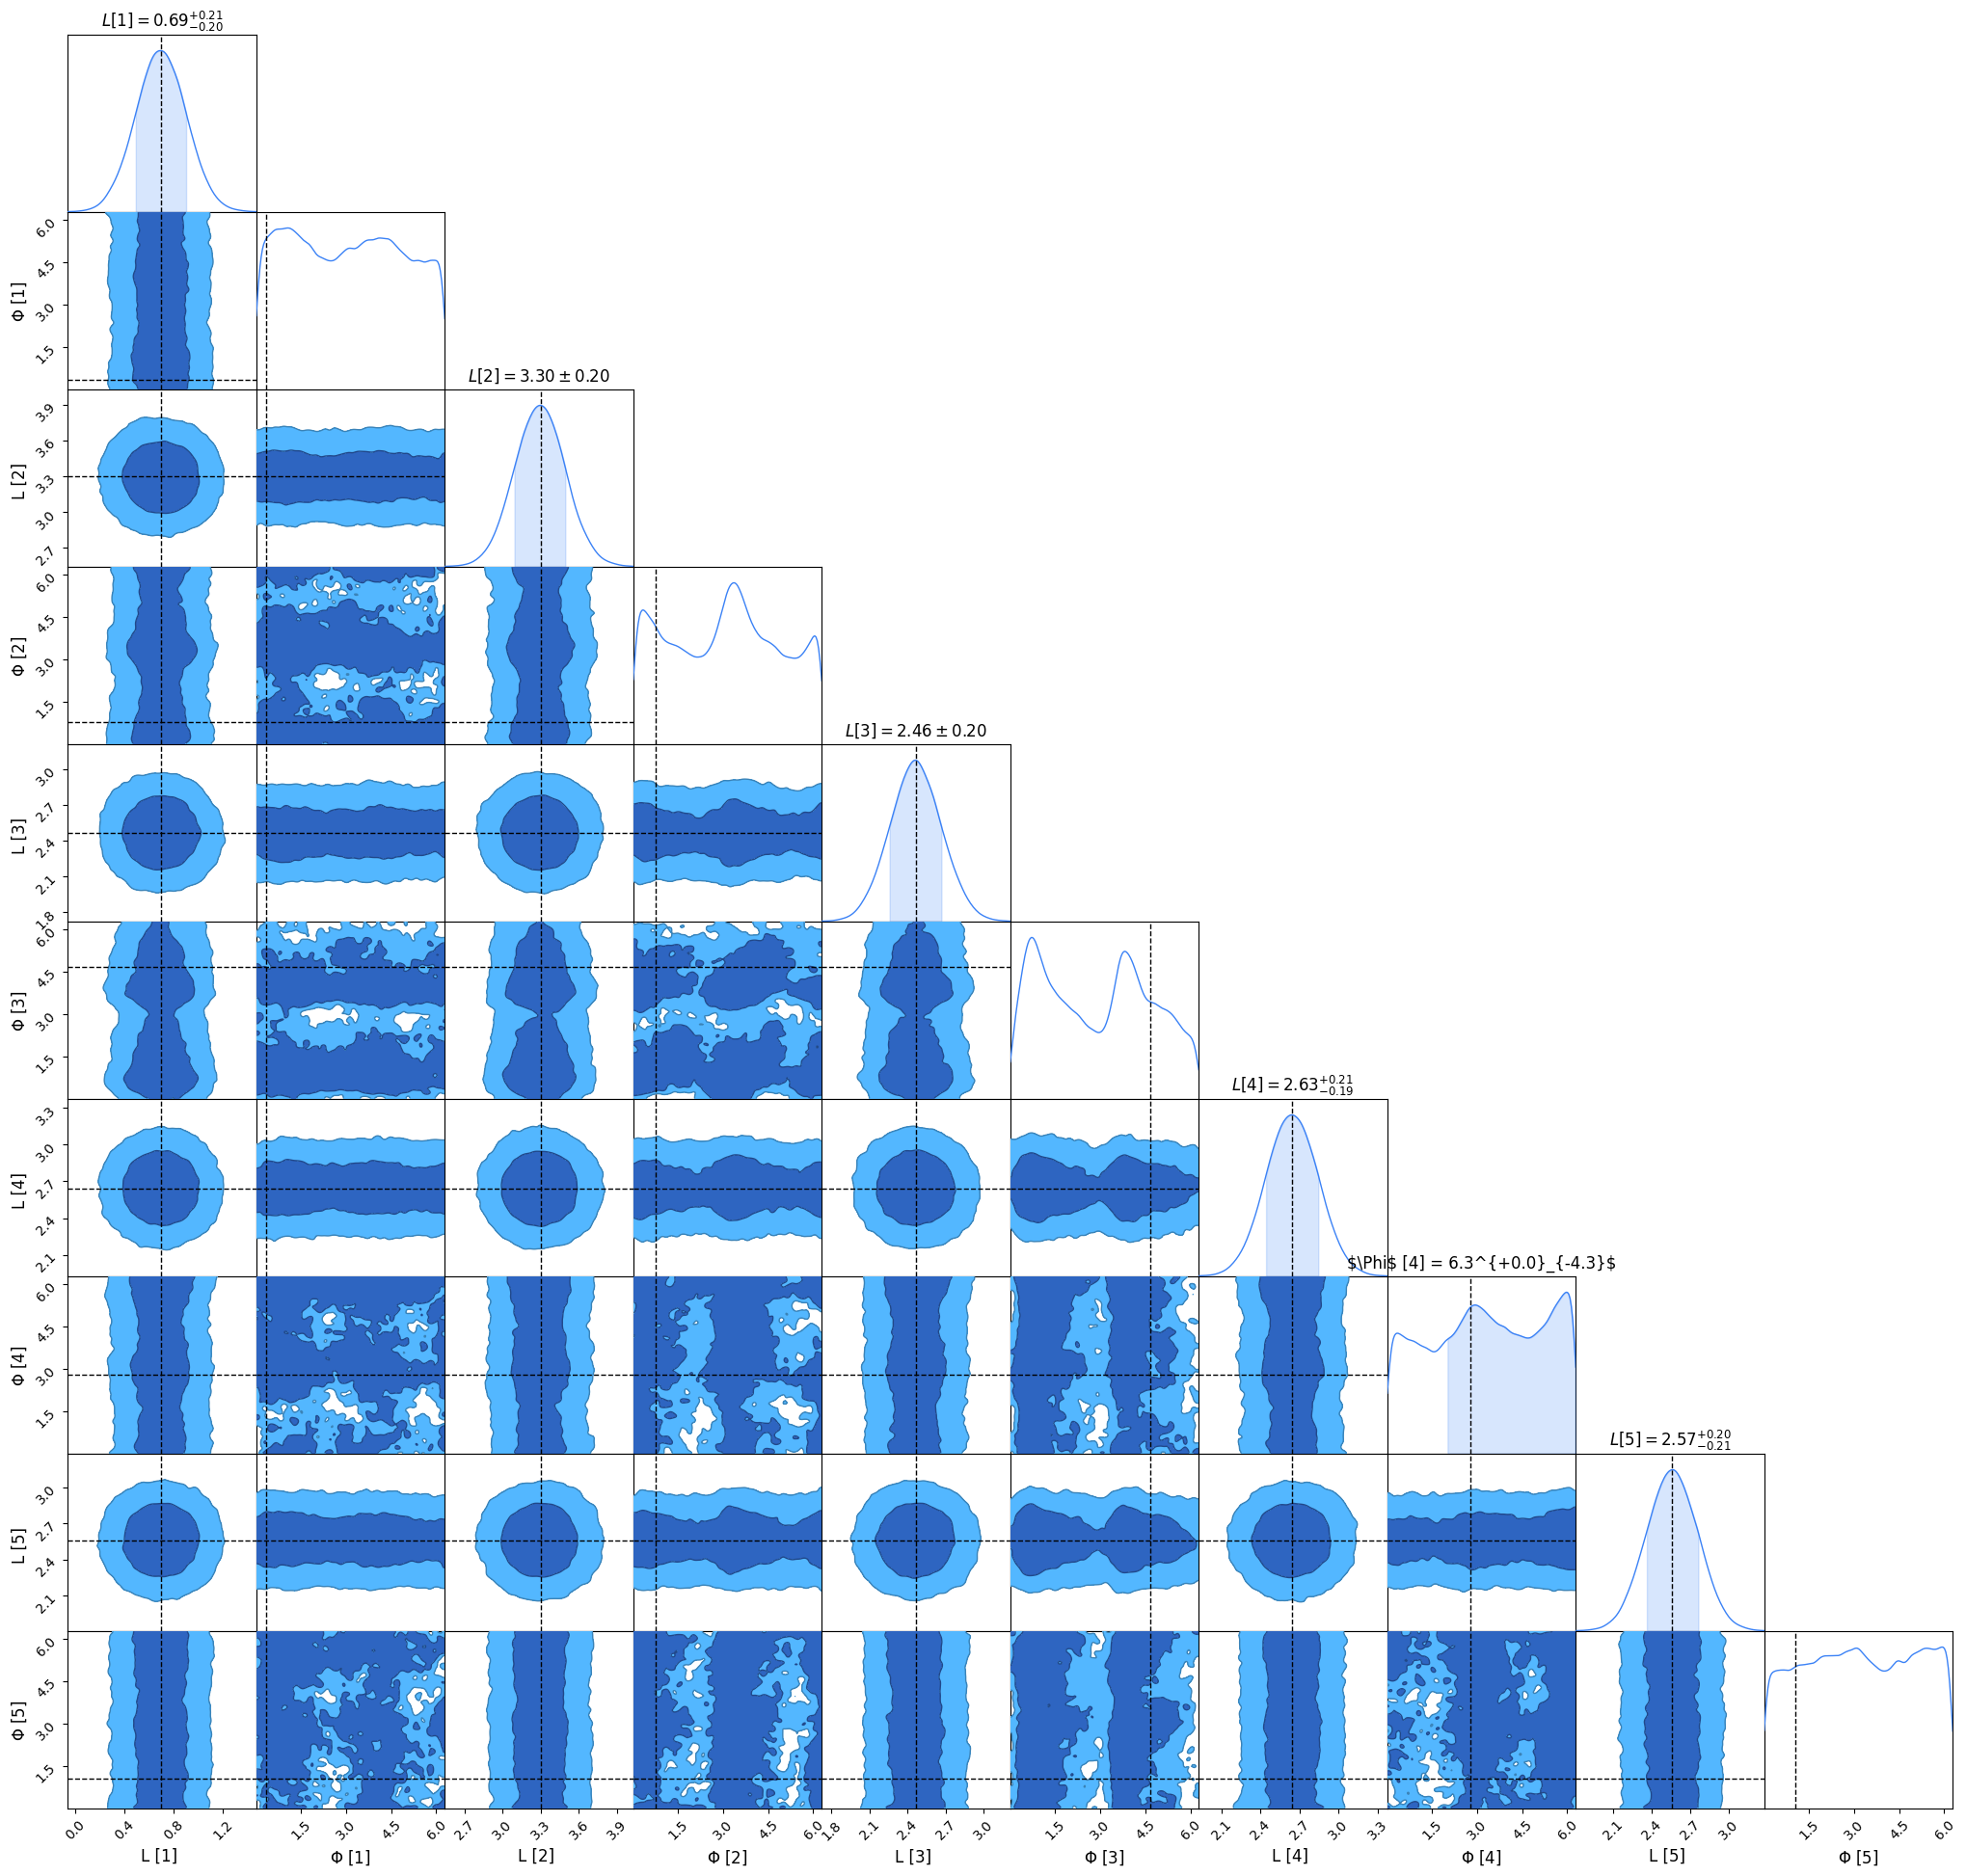

In [28]:
samples.corner_plt(param_ndxs=np.array([[pta.psr_dist_ndxs[i], pta.psr_phase_ndxs[i]]
                               for i in range(5)]).flatten(), burnin=10_000, thin=2)

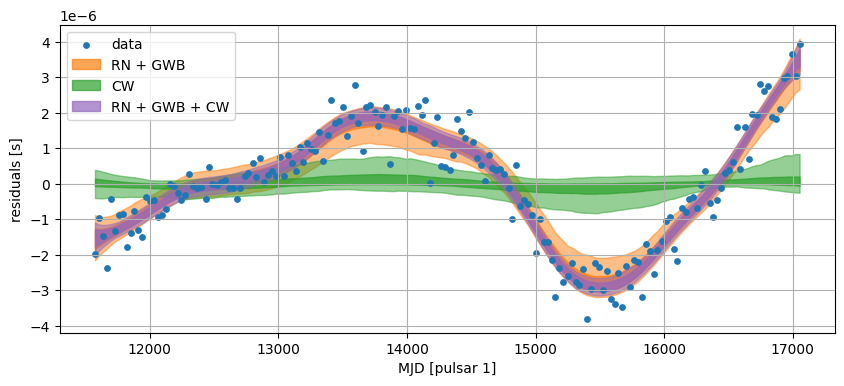

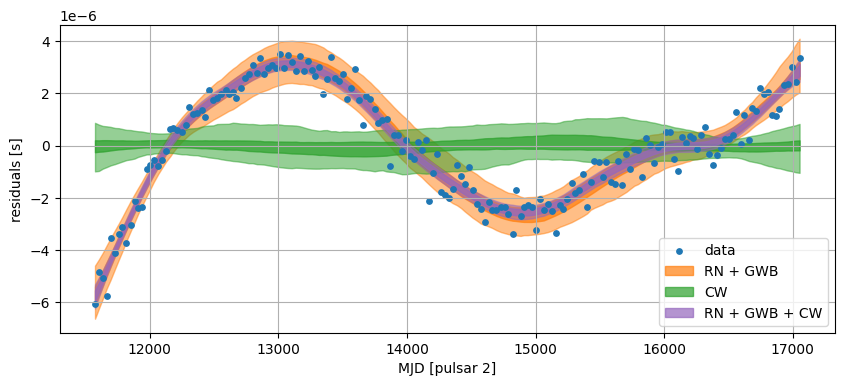

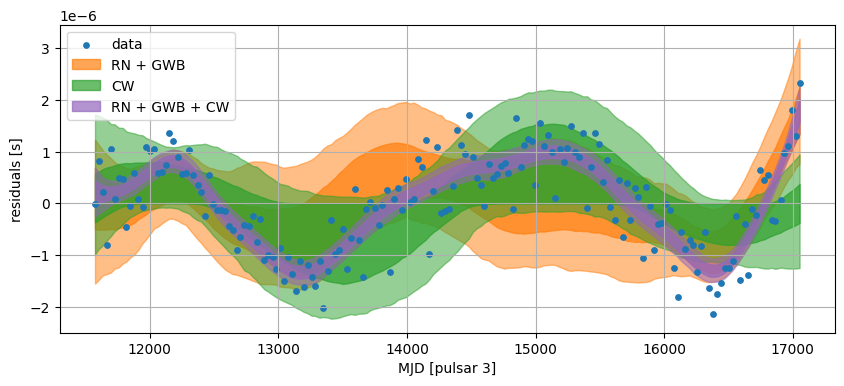

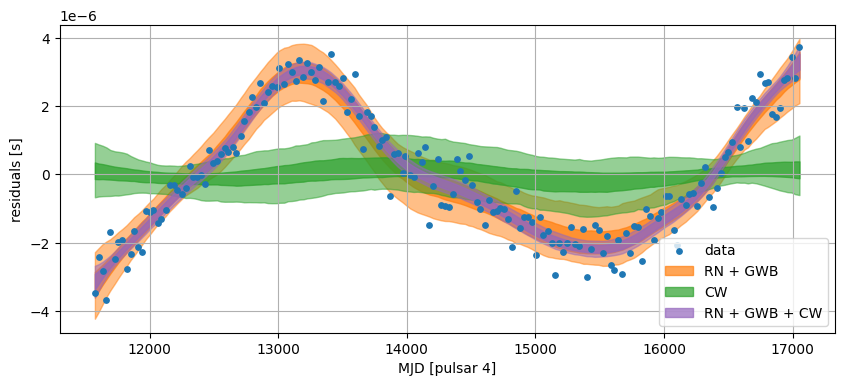

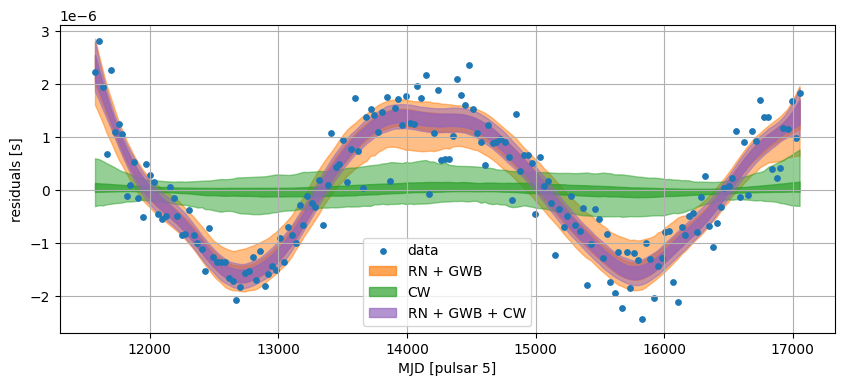

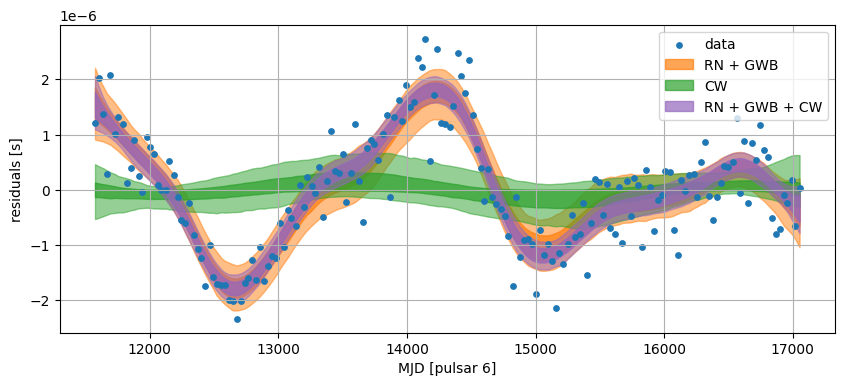

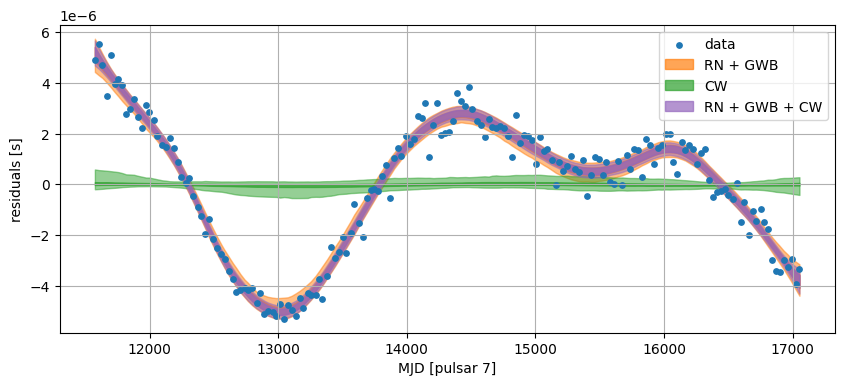

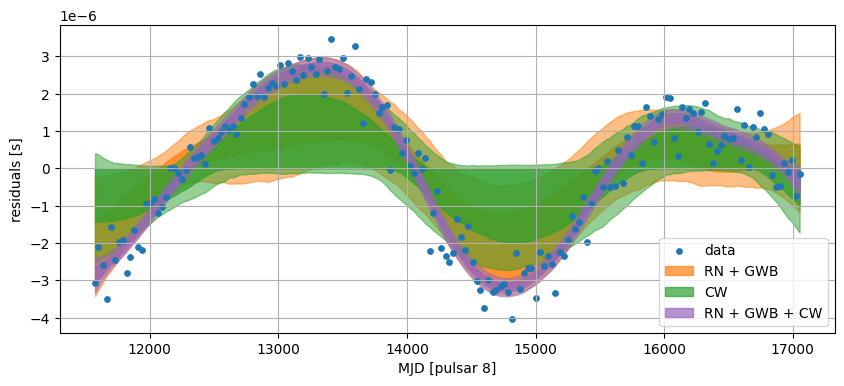

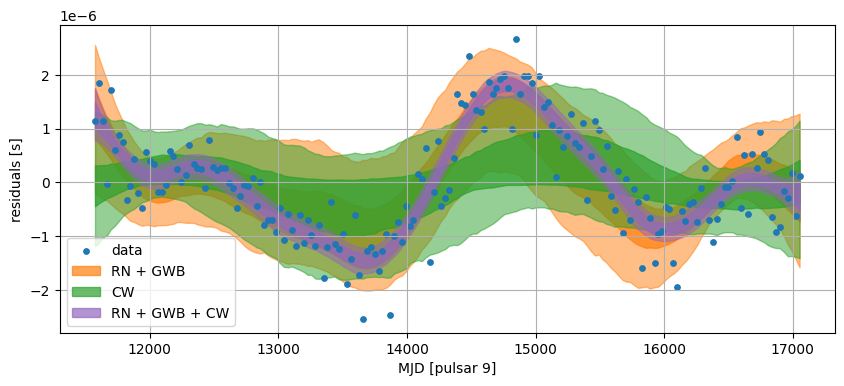

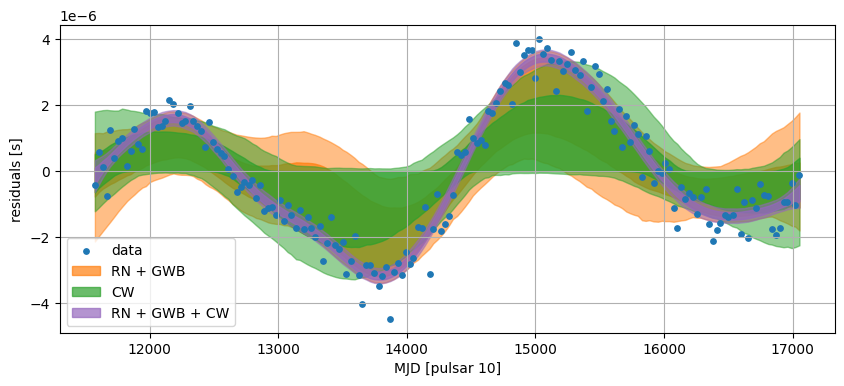

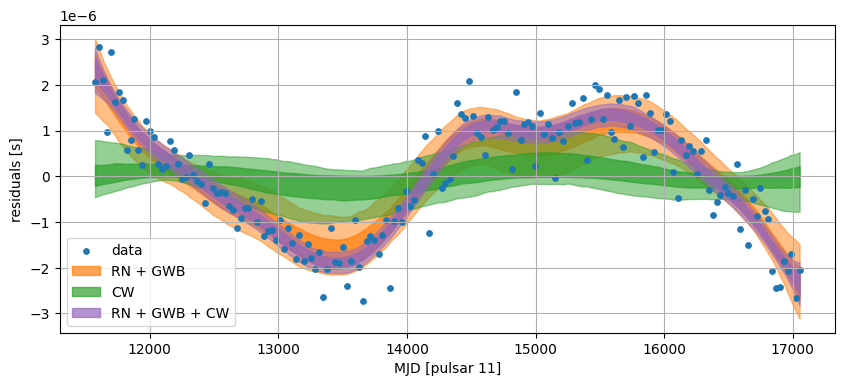

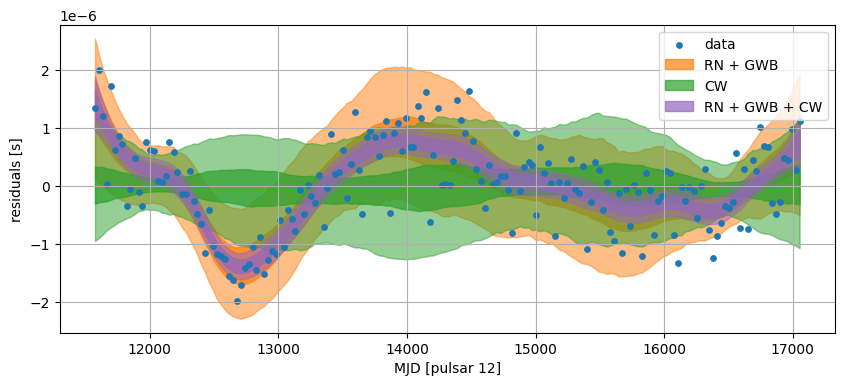

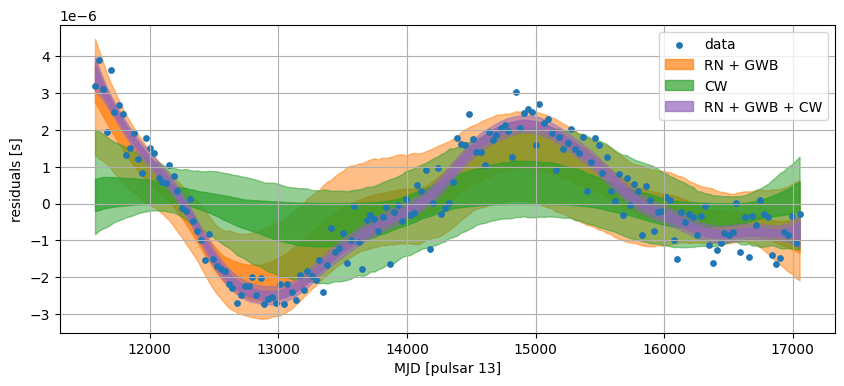

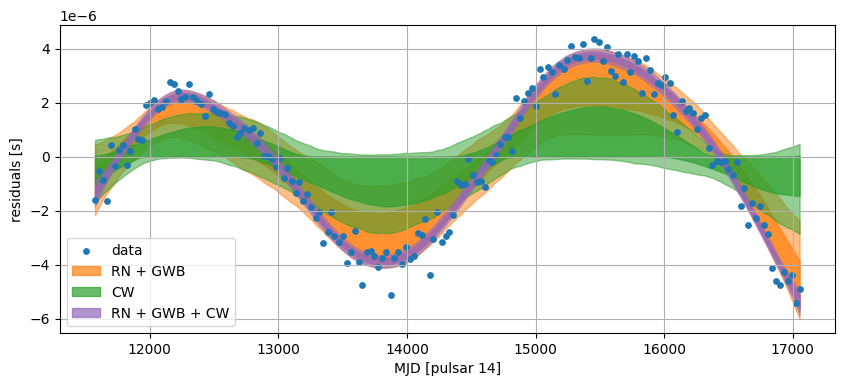

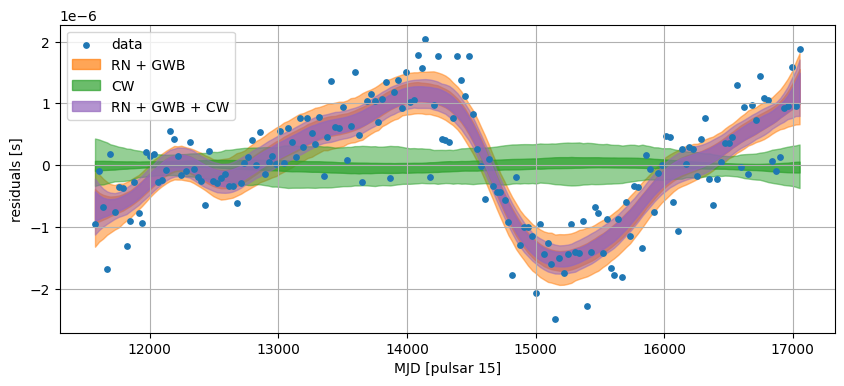

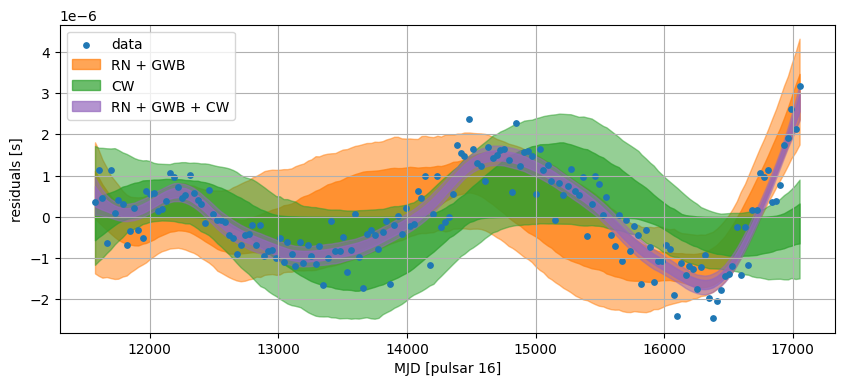

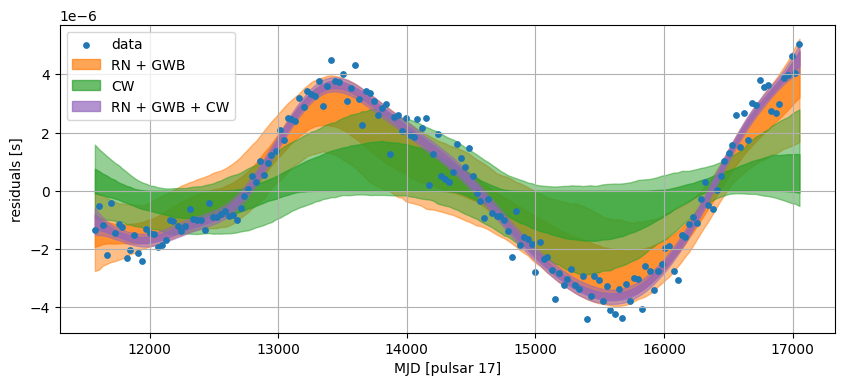

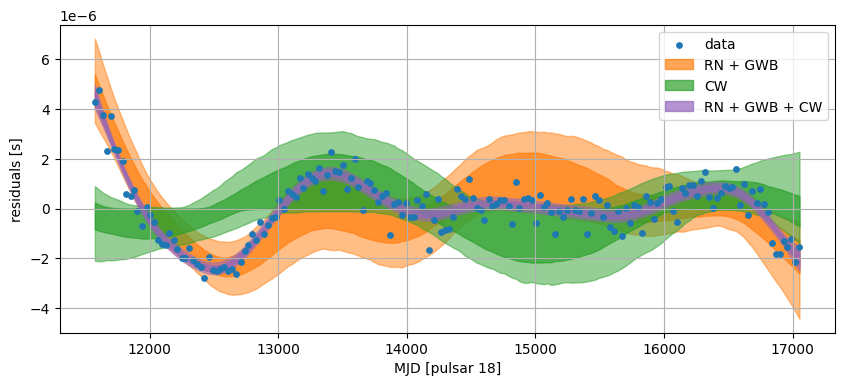

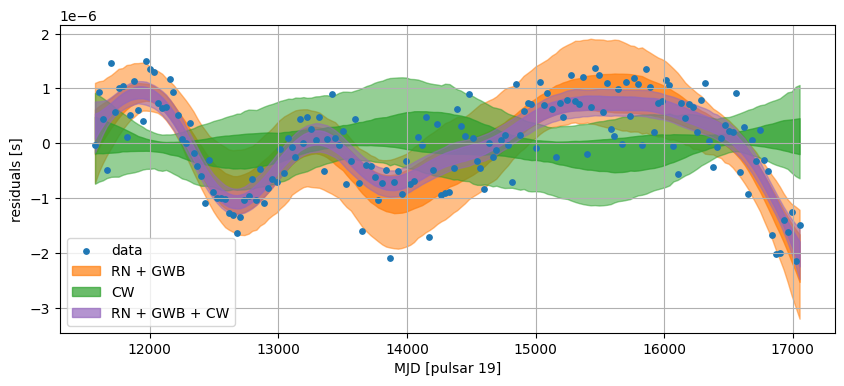

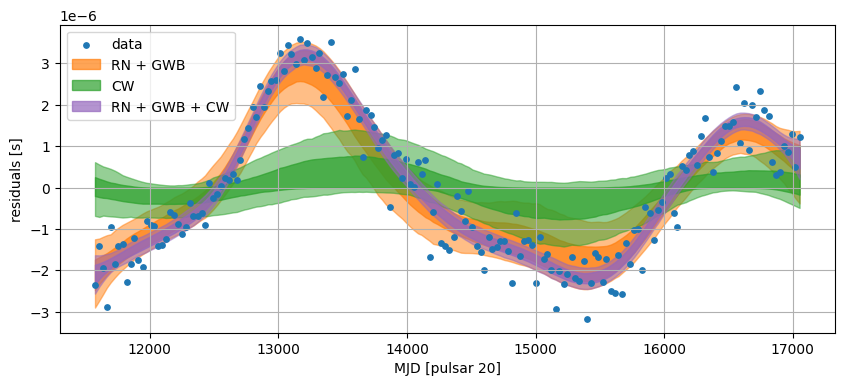

In [67]:
# Bayesogram
# psr_ndx = 0
for psr_ndx in np.arange(pta.Np):
    fair_draw_ndxs = np.random.choice(samples.samples.shape[0], (1000,))

    # percentile layers for plotting densities of samples
    # percentile_layers = [0.15, 2.5, 16.]
    percentile_layers = [2.5, 16.]
    alphas = [0.5, 0.7]

    # plot data, samples, and injected signals
    plt.figure(figsize=(10, 4))
    plt.scatter([], [], color='C0', s=15, label='data')

    # Bayesogram for RN + GWB
    if pta.model_rn or pta.model_gwb:
        rn_gwb_signals = np.array([pta.Rs[psr_ndx] @ pta.Fs[psr_ndx] @ samples.samples[ndx, pta.a_ndxs].reshape((pta.Np, pta.Na))[psr_ndx]
                                for ndx in fair_draw_ndxs])
        for percentile, alpha in zip(percentile_layers, alphas):
            if percentile != percentile_layers[-1]:
                plt.fill_between(pta.MJDs[psr_ndx], np.percentile(rn_gwb_signals, percentile, axis=0),
                                np.percentile(rn_gwb_signals, 100. - percentile, axis=0),
                                color='C1', alpha=alpha)
            else:
                plt.fill_between(pta.MJDs[psr_ndx], np.percentile(rn_gwb_signals, percentile, axis=0),
                                np.percentile(rn_gwb_signals, 100. - percentile, axis=0),
                                color='C1', alpha=alpha, label='RN + GWB')
        rn_gwb_residuals_inj = pta.Rs[psr_ndx] @ pta.Fs[psr_ndx] @ pta.a_inj.reshape((pta.Np, pta.Na))[psr_ndx]
        # plt.plot(pta.MJDs[psr_ndx], pta.Rs[psr_ndx] @ rn_gwb_residuals_inj, color='k')

    # Bayesogram for CW
    if pta.model_cw:
        a_cws = np.array([pta.get_CW_coefficients(samples.samples[ndx, pta.cw_psr_ndxs])[psr_ndx]
                    for ndx in fair_draw_ndxs])
        cw_signals = np.array([pta.Rs[psr_ndx] @ pta.Fs_cw[psr_ndx] @ a_cw for a_cw in a_cws])
        for percentile, alpha in zip(percentile_layers, alphas):
            if percentile != percentile_layers[-1]:
                plt.fill_between(pta.MJDs[psr_ndx], np.percentile(cw_signals, percentile, axis=0),
                                np.percentile(cw_signals, 100. - percentile, axis=0),
                                color='C2', alpha=alpha)
            else:
                plt.fill_between(pta.MJDs[psr_ndx], np.percentile(cw_signals, percentile, axis=0),
                                np.percentile(cw_signals, 100. - percentile, axis=0),
                                color='C2', alpha=alpha, label='CW')
        cw_signal_inj = pta.Rs[psr_ndx] @ pta.cw_delay_toa_input(pta.x_inj[pta.cw_psr_ndxs], pta.toas)[psr_ndx]
        # plt.plot(pta.MJDs[psr_ndx], pta.Rs[psr_ndx] @ cw_signal_inj, color='white')

    # Bayesogram for RN + GWB + CW
    if pta.model_rn and pta.model_gwb and pta.model_cw:
        signals = cw_signals + rn_gwb_signals
        for percentile, alpha in zip(percentile_layers, alphas):
            if percentile != percentile_layers[-1]:
                plt.fill_between(pta.MJDs[psr_ndx], np.percentile(signals, percentile, axis=0),
                                np.percentile(signals, 100. - percentile, axis=0),
                                color='C4', alpha=alpha)
            else:
                plt.fill_between(pta.MJDs[psr_ndx], np.percentile(signals, percentile, axis=0),
                                np.percentile(signals, 100. - percentile, axis=0),
                                color='C4', alpha=alpha, label='RN + GWB + CW')
        # plt.plot(pta.MJDs[psr_ndx], rn_gwb_residuals_inj + cw_signal_inj, color='purple', label='RN + GWB + CW injection')


    plt.scatter(pta.MJDs[psr_ndx], pta.Rs[psr_ndx] @ pta.residuals[psr_ndx], color='C0', s=15)
    plt.xlabel(f'MJD [pulsar {psr_ndx + 1}]')
    plt.ylabel('residuals [s]')
    plt.legend()
    plt.grid()
    plt.show()

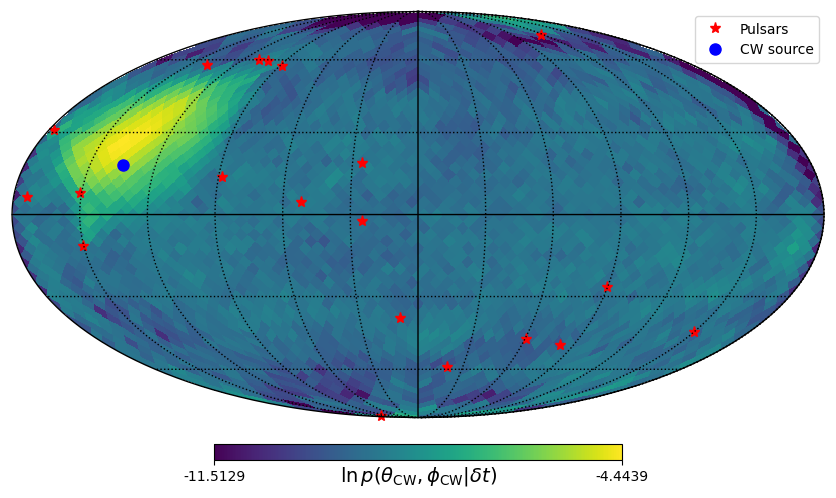

In [65]:
# sky map

# rotate sky map so bounds on azimuthal angle phi is on edges
phi_shift = np.pi

# pulsar positions
theta_psr = np.arccos(pta.psr_pos[:, 2])  # z = cos(theta)
phi_psr = np.mod(np.arctan2(pta.psr_pos[:, 1], pta.psr_pos[:, 0]), 2 * np.pi)

# resolution
nside = 16
npix = hp.nside2npix(nside)

# convert CW sky samples to healpix pixel indices
cos_gwtheta_samples = samples.samples[:, pta.cw_ndxs][:,-3]
gwphi_samples = samples.samples[:, pta.cw_ndxs][:,-2]
pix_indices = hp.ang2pix(nside, np.arccos(cos_gwtheta_samples), gwphi_samples + phi_shift)

# count number of samples in each pixel
density_map = np.bincount(pix_indices, minlength=npix).astype(float)

# normalize to show as a probability density
density_map /= np.sum(density_map)

# plot sky map with posterior density
hp.mollview(np.log(density_map + 1.e-5),
            title='',
            unit=r'$\ln p(\theta_\text{CW}, \phi_\text{CW} | \delta t)$',
            cmap='viridis')

# overlay pulsar positions
hp.projplot(theta_psr, phi_psr + phi_shift, 'r*', markersize=8)
hp.projplot([], [], 'r*', markersize=8, label='Pulsars')

# overlay injected GW source position
cos_gwtheta_inj = pta.x_inj[pta.cw_ndxs][-3]
gwphi_inj = pta.x_inj[pta.cw_ndxs][-2]
hp.projplot(np.arccos(cos_gwtheta_inj), gwphi_inj + phi_shift, 'bo', markersize=8, label='CW source')

hp.graticule()
plt.legend()
plt.show()

In [47]:
pta.x_inj[pta.gwb_ndxs]

Array([-14.        ,   4.33333333], dtype=float64)